In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [ ]:
train=pd.read_csv("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/data/train.csv")
test=pd.read_csv("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/data/test.csv")
test.shape

(625134, 9)

In [ ]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [ ]:
print("Min pickup time:",min(train['pickup_datetime']))
print("Max pickup time:",max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


In [ ]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date']= train['dropoff_datetime'].dt.date
train['dropoff_day']=train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour']=train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week']=train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [ ]:
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


> 하버사인 공식(최단거리 구하기)   
https://kayuse88.github.io/haversine/

In [ ]:
def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
train['trip_distance']=train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [ ]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


Text(0.5, 0, 'Trip Duration (in hour)')

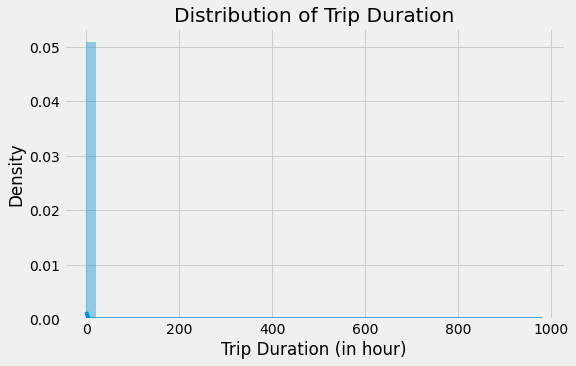

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

In [ ]:
outlier_trip_duration=train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,2016-01-05,5,0,Tuesday,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2016-02-13,13,22,Saturday,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,2016-01-05,5,6,Tuesday,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2016-02-13,13,22,Saturday,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

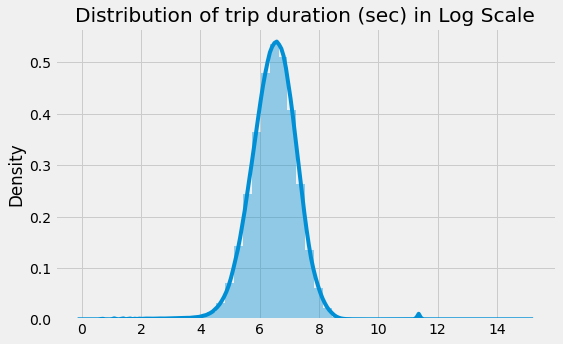

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

In [ ]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

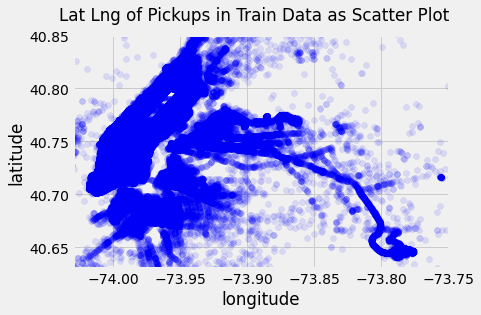

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [ ]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in drop.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)




drop_map

In [ ]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [ ]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

Text(0.5, 1.0, 'Pickup Hours Distribution')

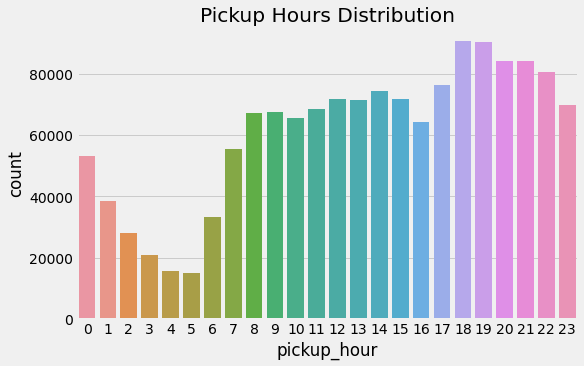

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

Text(0.5, 1.0, 'Dropoff Hours Distribution')

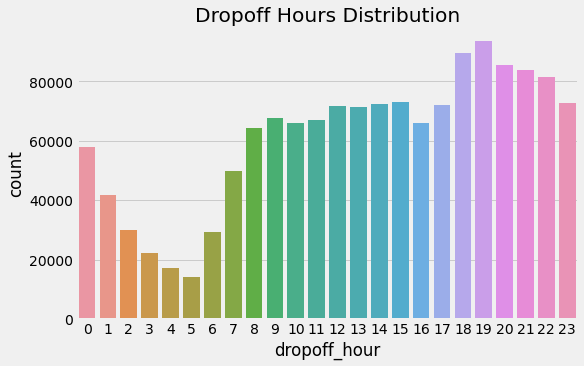

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Text(0.5, 1.0, 'Distribution of Pickups over time')

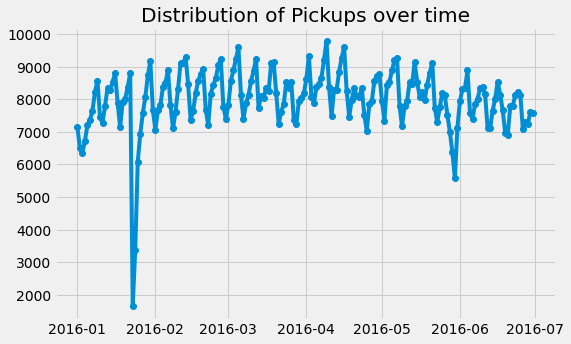

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')


plt.title("Distribution of Pickups over time")

Text(0.5, 0, 'Trip Distance (log)')

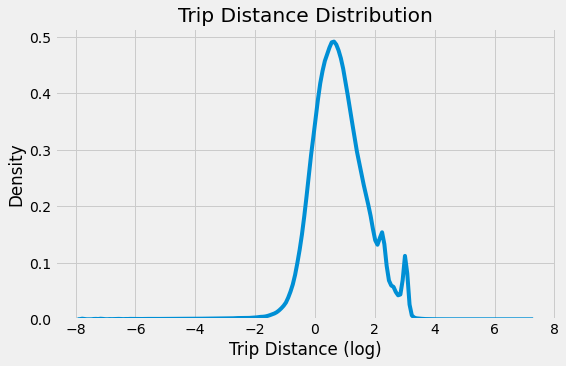

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

Text(0, 0.5, 'Trip Duration (log scale)')

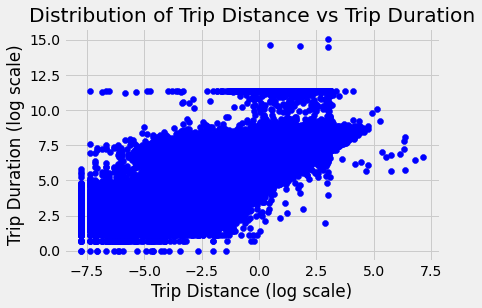

In [ ]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

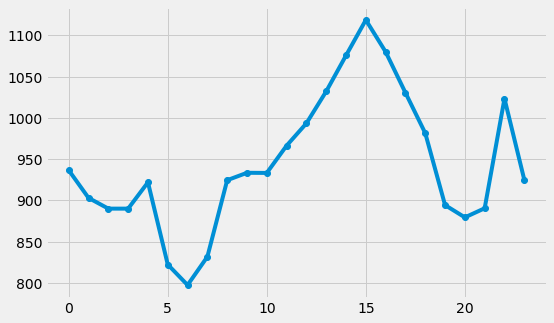

In [ ]:
avg_duration_hour=train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

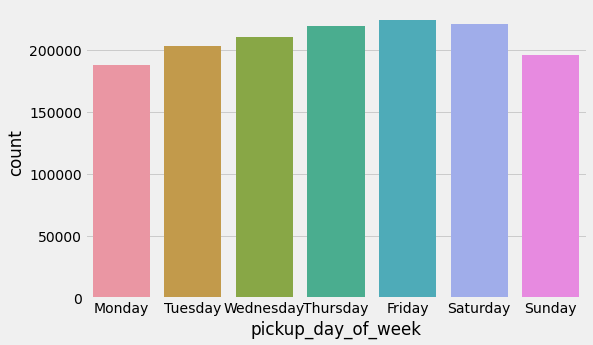

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

In [ ]:
avg_duration_day=train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

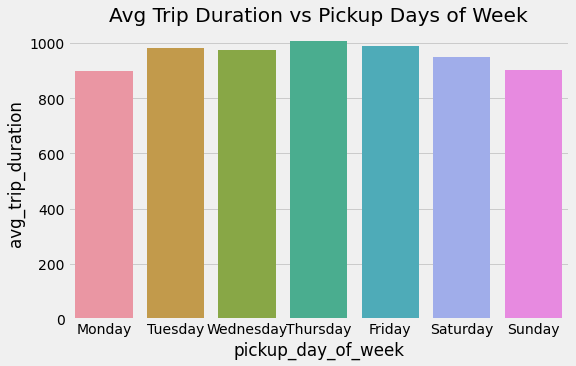

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_trip_duration',data=avg_duration_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

In [ ]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

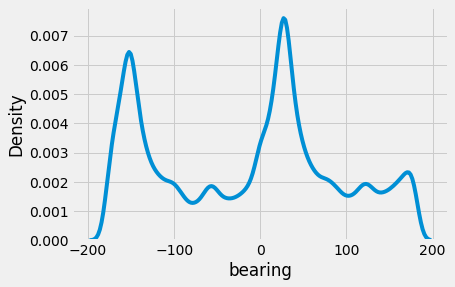

In [ ]:
sns.kdeplot(train['bearing'])

Text(0, 0.5, 'Trip Duration (log scale)')

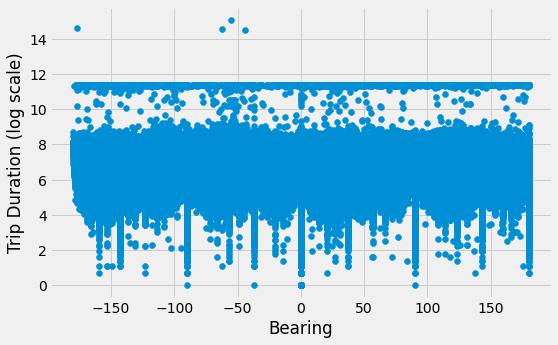

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

In [ ]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

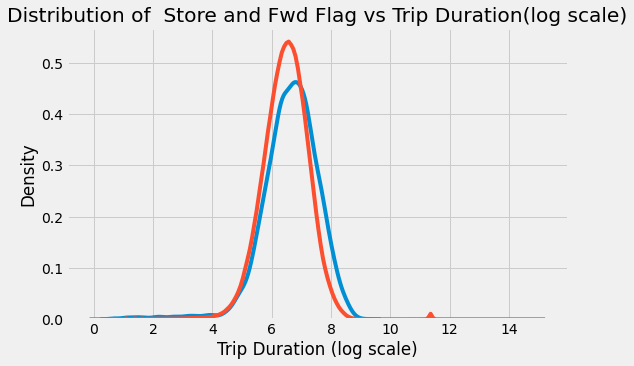

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

(-74.03, -73.75)

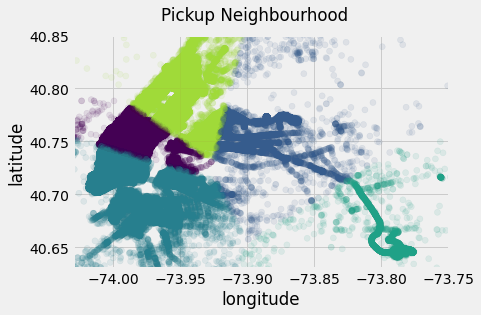

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

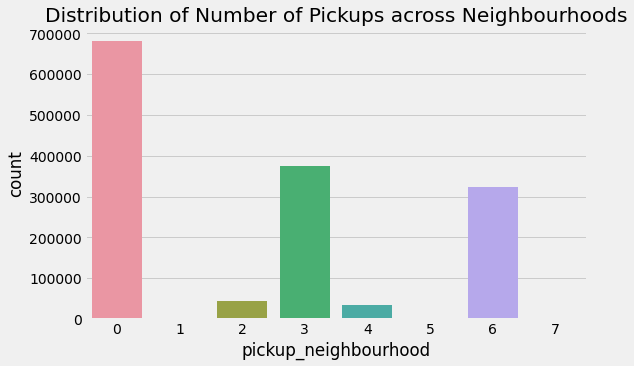

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

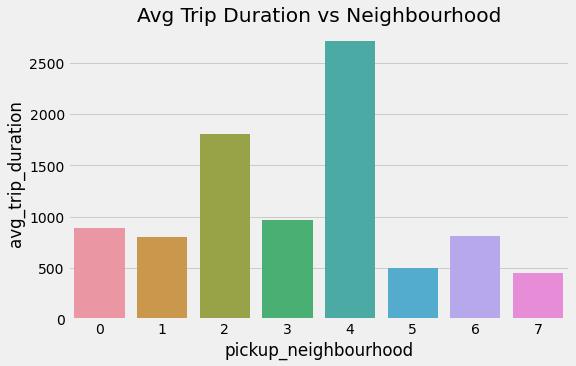

In [ ]:
avg_duration_neighbourhood=train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood',y='avg_trip_duration',data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

## Distribution of Average speed

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

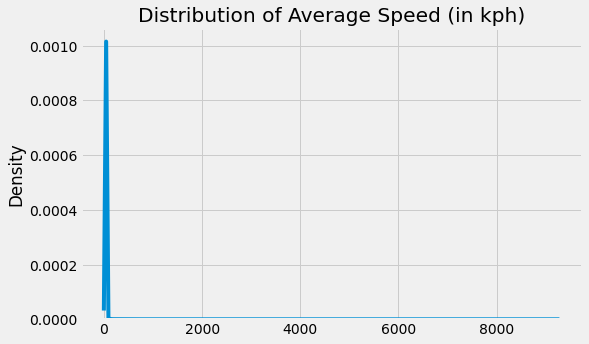

In [ ]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [ ]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458588 kph


## Average Speed across days of week - this is indication of traffic speed.

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

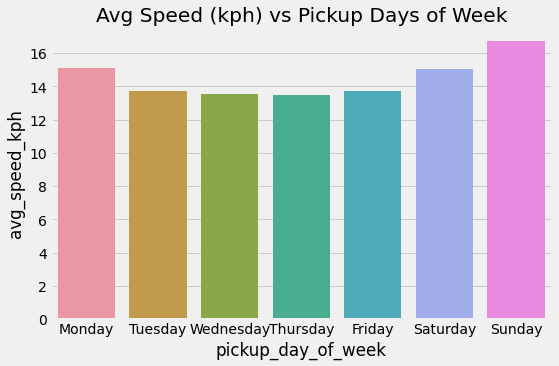

In [ ]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

The average speed is higher on sunday and monday.

## Feature Engineering on Test Data

In [ ]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

## Building Models

From the training data we need to drop "dropoff datetime features". We also only keep lat lng rounded to 3 decimal places

In [ ]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

We have to predict trip_duration. We will convert this to log scale and predict

In [ ]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


Let us also encode day of week as numbers

In [ ]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [ ]:
training['pickup_day_of_week']=training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week']=testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [ ]:
training.to_csv("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/input_training.csv",index=False)
testing.to_csv("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/input_testing.csv",index=False)
del training
del testing
del train
del test

In [ ]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
   
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [ ]:
train,test=readInputAndEncode("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [ ]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',split=0.25,imputation=True):
    labels=np.array(train[target])
    training=train.drop(target, axis = 1)
    training = np.array(training)
    testing=np.array(test)
    if imputation==True:
        imputer=SimpleImputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

In [ ]:
train_features,validation_features,train_labels,validation_labels,testing=GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

## Apply Linear Regression

In [ ]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
valid_pred=lm.predict(validation_features)

In [ ]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.40034228168241537


In [ ]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False) #0.64221 on Leader board
del submit

## Apply Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
rf.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.1658924043397965


In [ ]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("/content/drive/My Drive/kaggle/04.New York City Taxi Trip Duration/submission_random_forest_baseline.csv",index=False)